# Example: Path planning problem solved by [Uniform grid abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).


This example was borrowed from [reissig2016feedback; IX. Examples, A](@cite) whose dynamics comes from the model given in [aastrom2007feedback; Ch. 2.4](@cite).
This is a **reachability problem** for a **continuous system**.

Let us consider the 3-dimensional state space control system of the form
$$
\dot{x} = f(x, u)
$$
with $f: \mathbb{R}^3 × U ↦ \mathbb{R}^3$ given by
$$
f(x,(u_1,u_2)) = \begin{bmatrix} u_1 \cos(α+x_3)\cos(α)^{-1} \\ u_1 \sin(α+x_3)\cos(α)^{-1} \\ u_1 \tan(u_2)  \end{bmatrix}
$$
and with $U = [−1, 1] \times [−1, 1]$ and $α = \arctan(\tan(u_2)/2)$. Here, $(x_1, x_2)$ is the position and $x_3$ is the
orientation of the vehicle in the 2-dimensional plane. The control inputs $u_1$ and $u_2$ are the rear
wheel velocity and the steering angle.
The control objective is to drive the vehicle which is situated in a maze made of obstacles from an initial position to a target position.


In order to study the concrete system and its symbolic abstraction in a unified framework, we will solve the problem
for the sampled system with a sampling time $\tau$.
For the construction of the relations in the abstraction, it is necessary to over-approximate attainable sets of
a particular cell. In this example, we consider the used of a growth bound function [reissig2016feedback; VIII.2, VIII.5](@cite) which is one of the possible methods to over-approximate
attainable sets of a particular cell based on the state reach by its center.

For this reachability problem, the abstraction controller is built by solving a fixed-point equation which consists in computing the pre-image
of the target set.

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots](https://github.com/JuliaPlots/Plots.jl).

In [1]:
using StaticArrays, Plots

At this point, we import Dionysos and JuMP.

In [2]:
using Dionysos, JuMP

### Definition of the problem

We define the problem using JuMP as follows.
We first create a JuMP model:

In [3]:
model = Model(Dionysos.Optimizer)

A JuMP Model
├ solver: unknown
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

Define the state variables: x1(t), x2(t), x3(t)

In [4]:
x_low, x_upp = [0.0, 0.0, -pi - 0.4], [4.0, 10.0, pi + 0.4]
x_start = [0.4, 0.4, 0.0]
@variable(model, x_low[i] <= x[i = 1:3] <= x_upp[i], start = x_start[i])

3-element Vector{JuMP.VariableRef}:
 x[1]
 x[2]
 x[3]

Define the control variables: u1(t), u2(t)

In [5]:
@variable(model, -1 <= u[1:2] <= 1)

2-element Vector{JuMP.VariableRef}:
 u[1]
 u[2]

Set α(t) = arctan(tan(u2(t)) / 2)

In [6]:
@expression(model, α, atan(tan(u[2]) / 2))

@constraint(model, ∂(x[1]) == u[1] * cos(α + x[3]) * sec(α))
@constraint(model, ∂(x[2]) == u[1] * sin(α + x[3]) * sec(α))
@constraint(model, ∂(x[3]) == u[1] * tan(u[2]))

x_target = [3.3, 0.5, 0]

@constraint(model, final(x[1]) in MOI.Interval(3.0, 3.6))
@constraint(model, final(x[2]) in MOI.Interval(0.3, 0.8))
@constraint(model, final(x[3]) in MOI.Interval(-100.0, 100.0))

final(x[3]) ∈ [-100, 100]

Obstacle boundaries (provided)

In [7]:
x1_lb = [1.0, 2.2, 2.2]
x1_ub = [1.2, 2.4, 2.4]
x2_lb = [0.0, 0.0, 6.0]
x2_ub = [9.0, 5.0, 10.0]

3-element Vector{Float64}:
  9.0
  5.0
 10.0

Function to add rectangular obstacle avoidance constraints

In [8]:
for i in eachindex(x1_ub)
    @constraint(
        model,
        x[1:2] ∉ MOI.HyperRectangle([x1_lb[i], x2_lb[i]], [x1_ub[i], x2_ub[i]])
    )
end

### Definition of the abstraction

Definition of the grid of the state-space on which the abstraction is based (origin `x0` and state-space discretization `h`):

We define the growth bound function of $f$:

In [9]:
function jacobian_bound(u)
    β = abs(u[1] / cos(atan(tan(u[2]) / 2)))
    return StaticArrays.SMatrix{3, 3}(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, β, β, 0.0)
end
set_attribute(model, "jacobian_bound", jacobian_bound)

set_attribute(model, "time_step", 0.3)

x0 = SVector(0.0, 0.0, 0.0);
h = SVector(0.2, 0.2, 0.2);
set_attribute(model, "state_grid", Dionysos.Domain.GridFree(x0, h))

Definition of the grid of the input-space on which the abstraction is based (origin `u0` and input-space discretization `h`):

In [10]:
u0 = SVector(0.0, 0.0);
h = SVector(0.3, 0.3);
set_attribute(model, "input_grid", Dionysos.Domain.GridFree(u0, h))

optimize!(model)

>>Setting up the model
>>Model setup complete
┌ Warning: Noise is not yet accounted for in system abstraction.
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/bkavK/src/optim/abstraction/UniformGridAbstraction/empty_problem.jl:216
compute_symmodel_from_controlsystem! started
compute_symmodel_from_controlsystem! terminated with success: 9705631 transitions created
┌ Warning: The `state_cost` and `transition_cost` are not yet fully implemented
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/bkavK/src/optim/abstraction/UniformGridAbstraction/optimal_control_problem.jl:94

 Reachability: terminated with success


Get the results

In [11]:
abstract_system = get_attribute(model, "abstract_system");
abstract_problem = get_attribute(model, "abstract_problem");
abstract_controller = get_attribute(model, "abstract_controller");
concrete_controller = get_attribute(model, "concrete_controller")
concrete_problem = get_attribute(model, "concrete_problem");
concrete_system = concrete_problem.system

MathematicalSystems.ConstrainedBlackBoxControlContinuousSystem{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xbe033a95, 0x3d29f15e, 0x74c8bbf6, 0x2a94657e, 0xb57338e2), Expr}, Dionysos.Utils.LazySetMinus{Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{3, Float64}}, Dionysos.Utils.LazyUnionSetArray{Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{3, Float64}}}}, Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{2, Float64}}}(RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xbe033a95, 0x3d29f15e, 0x74c8bbf6, 0x2a94657e, 0xb57338e2), Expr}(:(#= /home/runner/.julia/packages/Symbolics/Pl7kR/src/build_function.jl:346 =# @inbounds begin
          #= /home/runner/.julia/packages/Symbolics/Pl7kR/src/build_function.jl:346 =#
          begin
              #= /home/runner/.julia/packages/SymbolicUtils/Su6xO/src/code

### Trajectory display
We choose a stopping criterion `reached` and the maximal number of steps `nsteps` for the sampled system, i.e. the total elapsed time: `nstep`*`tstep`
as well as the true initial state `x0` which is contained in the initial state-space `_I_` defined previously.

In [12]:
nstep = 100
function reached(x)
    if x ∈ concrete_problem.target_set
        return true
    else
        return false
    end
end

x0 = SVector(0.4, 0.4, 0.0)
control_trajectory = Dionysos.System.get_closed_loop_trajectory(
    get_attribute(model, "discretized_system"),
    concrete_controller,
    x0,
    nstep;
    stopping = reached,
)

using Plots

Here we display the coordinate projection on the two first components of the state space along the trajectory.

In [13]:
fig = plot(; aspect_ratio = :equal);

We display the concrete domain

In [14]:
plot!(concrete_system.X; color = :yellow, opacity = 0.5);

We display the abstract domain

In [15]:
plot!(abstract_system.Xdom; color = :blue, opacity = 0.5);

We display the concrete specifications

In [16]:
plot!(concrete_problem.initial_set; color = :green, opacity = 0.2);
plot!(concrete_problem.target_set; dims = [1, 2], color = :red, opacity = 0.2);

We display the abstract specifications

In [17]:
plot!(
    Dionysos.Symbolic.get_domain_from_states(abstract_system, abstract_problem.initial_set);
    color = :green,
);
plot!(
    Dionysos.Symbolic.get_domain_from_states(abstract_system, abstract_problem.target_set);
    color = :red,
);

We display the concrete trajectory

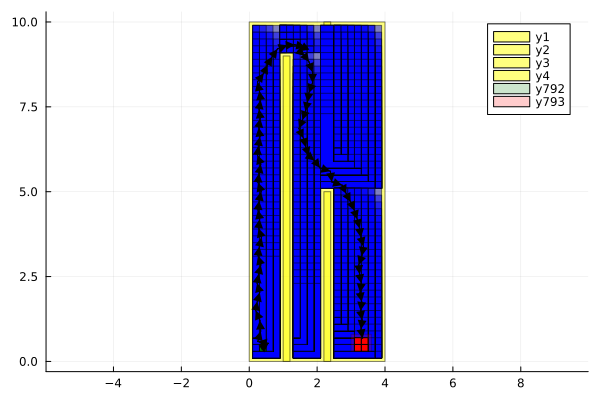

In [18]:
plot!(control_trajectory; ms = 0.5)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*